In [4]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    return (in_channels*kernel_size**2+bias)*out_channels

In [2]:
import warnings
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T

from PIL import Image 
from matplotlib import cm 
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

In [3]:
from IPython.display import clear_output

In [4]:
warnings.filterwarnings('ignore')

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer


def create_model():
    model = nn.Sequential(
        nn.Linear(100,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )

    return  model

def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()
    errors = 0
    for x, y in data_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        print(f'{loss.item():.5f}')
        errors+= loss.item()
        optimizer.step()
    return errors/len(data_loader)


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()
    errors = 0
    for x,y in data_loader:
        y_pred = model.forward(x)
        errors += loss_fn(y_pred, y)
    return errors/len(data_loader)

In [6]:
minist_train = MNIST('../datasets/mnist',
                    train = True,
                    download=True)

In [7]:
type(minist_train[0])

tuple

In [8]:
minist_train[16][0]

In [15]:
minist_train = MNIST('../datasets/mnist',
                    train = True,
                    download=True,
                    transform=T.ToTensor())

In [16]:
minist_test = MNIST('../datasets/mnist',
                    train = False,
                    download=True,
                transform=T.ToTensor())

In [24]:
train_loader = DataLoader(minist_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(minist_test, batch_size=128, shuffle=True)

In [31]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [32]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        
        x, y = x.to(device), y.to(device)
        
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [33]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [34]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 652),
    nn.ReLU(),
    nn.Linear(652, 520),
    nn.ReLU(),
    nn.Linear(520, 388),
    nn.ReLU(),
    nn.Linear(388, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)



optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

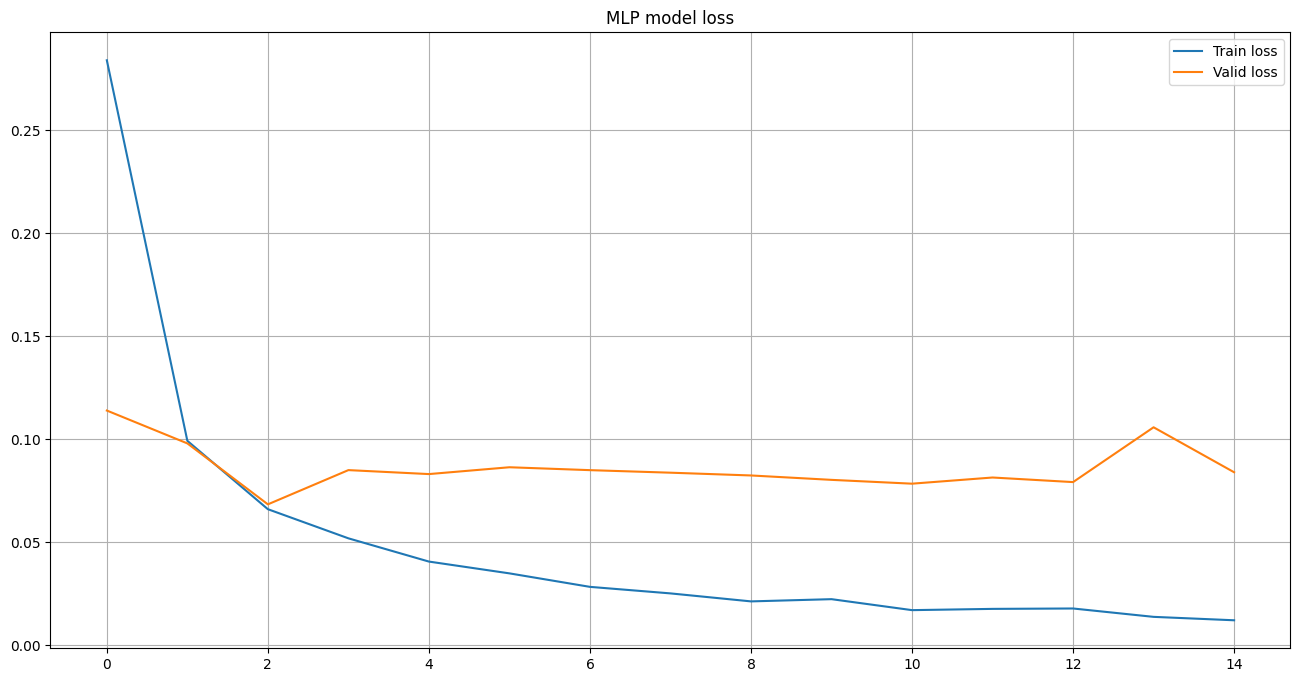

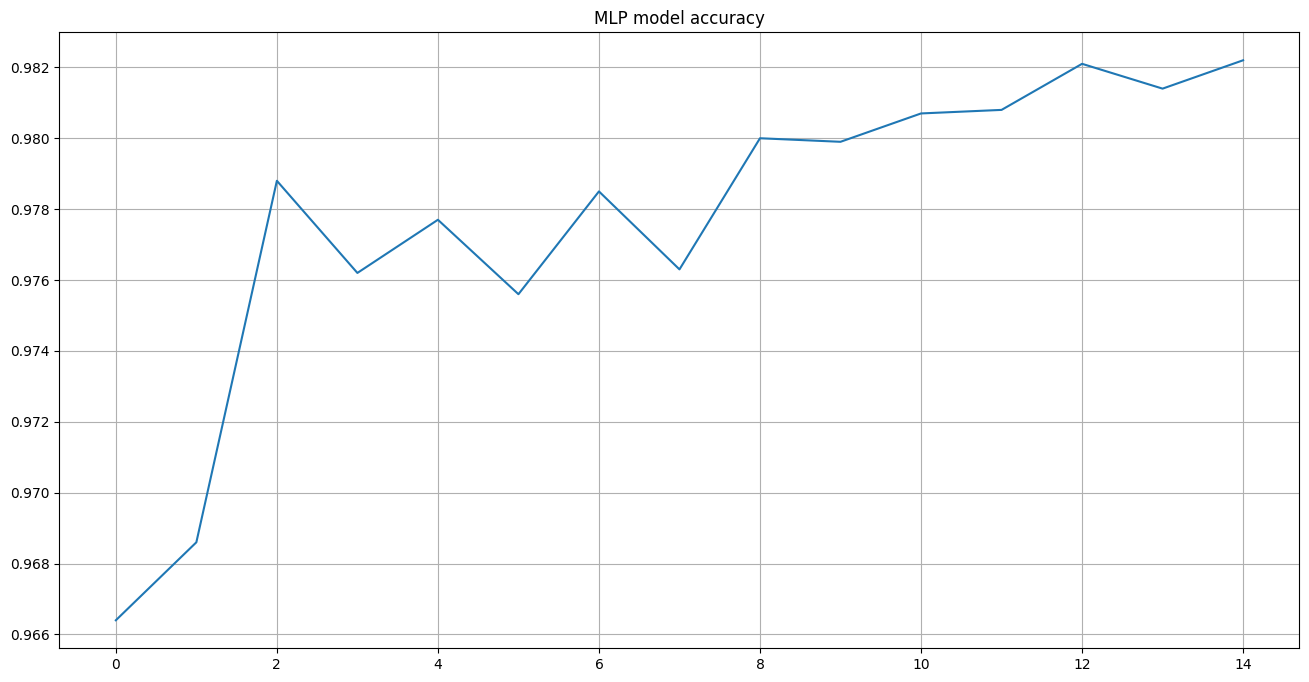

Total training and evaluation time 149.03189


In [35]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [38]:
torch.save(first_model.state_dict(), 'model.pt')

In [36]:
if torch.cuda.is_available():
    print("GPU is available")
    # Получаем количество доступных GPU
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce GTX 1060 6GB


In [26]:
from numba import cuda # Библиотека Nvidia для работы с GPU 

@cuda.jit('void(float32[:], float32[:], float32[:])') #Динамический компилятор Cuda 
def cuda_addition(a,b,c):
    """Поток будет выполнять эту функцию ядра."""
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    if i > c.size:
        return
    c[i] = a[i]+b[i] #Perform the addition
 
# Подробности об устройстве
device = cuda.get_current_device()

# Перенос с хоста на устройство
d_a = cuda.to_device(a)  # Перенос данных в глобальную память GPU
d_b = cuda.to_device(b)  # Перенос данных в глобальную память GPU
d_c = cuda.device_array_like(a)

tpb = device.WARP_SIZE       #blocksize или количество потоков на блок, стандартное значение = 32
bpg = int(np.ceil((n)/tpb))  # блоков на грид

cuda_addition[bpg, tpb](d_a, d_b, d_c) # вызов ядра

# Перенос вывода с устройства на хост
c = d_c.copy_to_host()
print(c)

NvvmSupportError: libNVVM cannot be found. Do `conda install cudatoolkit`:
Could not find module 'nvvm.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [31]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     ----- ---------------------------------- 0.5/4.1 MB 10.7 MB/s eta 0:00:01
     ---------- ----------------------------- 1.1/4.1 MB 11.1 MB/s eta 0:00:01
     --------------- ------------------------ 1.6/4.1 MB 11.4 MB/s eta 0:00:01
     --------------------- ------------------ 2.2/4.1 MB 11.4 MB/s eta 0:00:01
     -------------------------- ------------- 2.7/4.1 MB 11.6 MB/s eta 0:00:01
     -------------------------------- ------- 3.3/4.1 MB 11.6 MB/s eta 0:00:01
     ------------------------------------- -- 3.8/4.1 MB 12.1 MB/s eta 0:00:01
     ---------------------------------------- 4.1/4.1 MB 11.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 10.0 MB/s eta 0:04:02
     ---------------------------------------- 0.0/2.4 GB 10.9 MB/s eta 0:03:43
     ----

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(4 * 4 * 64, 520),
    
    nn.ReLU(),
    nn.Linear(520, 256),

    
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

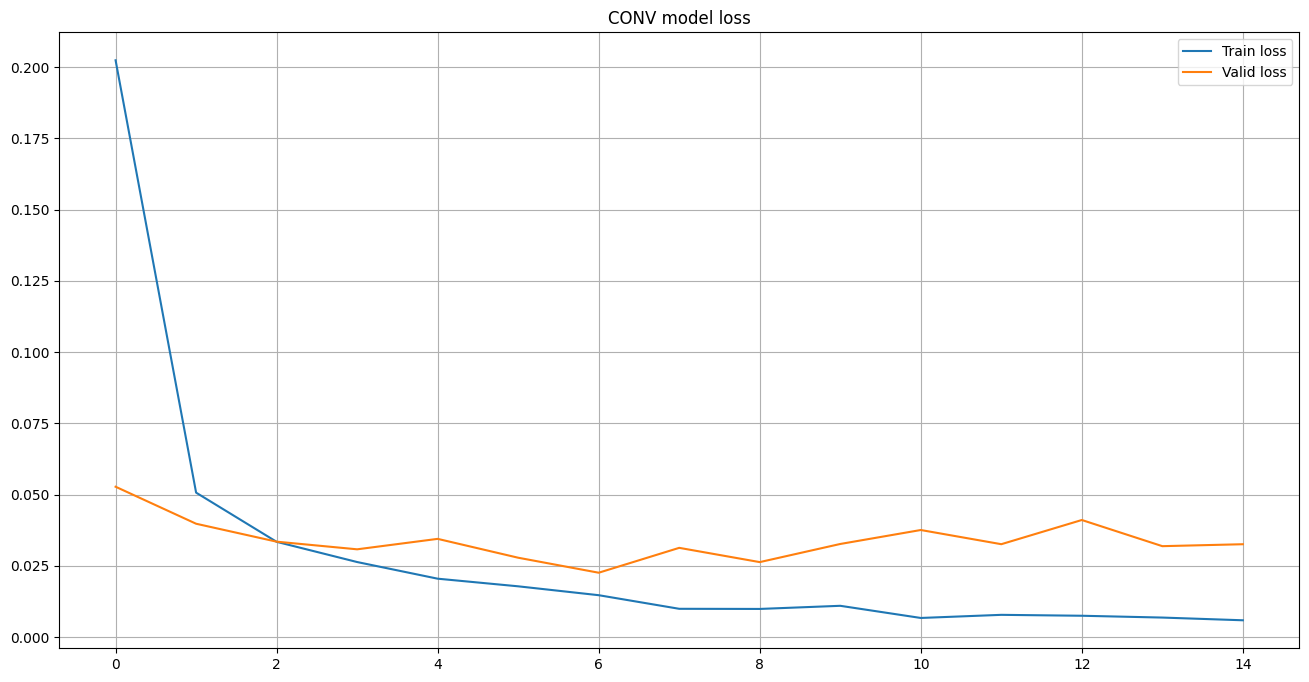

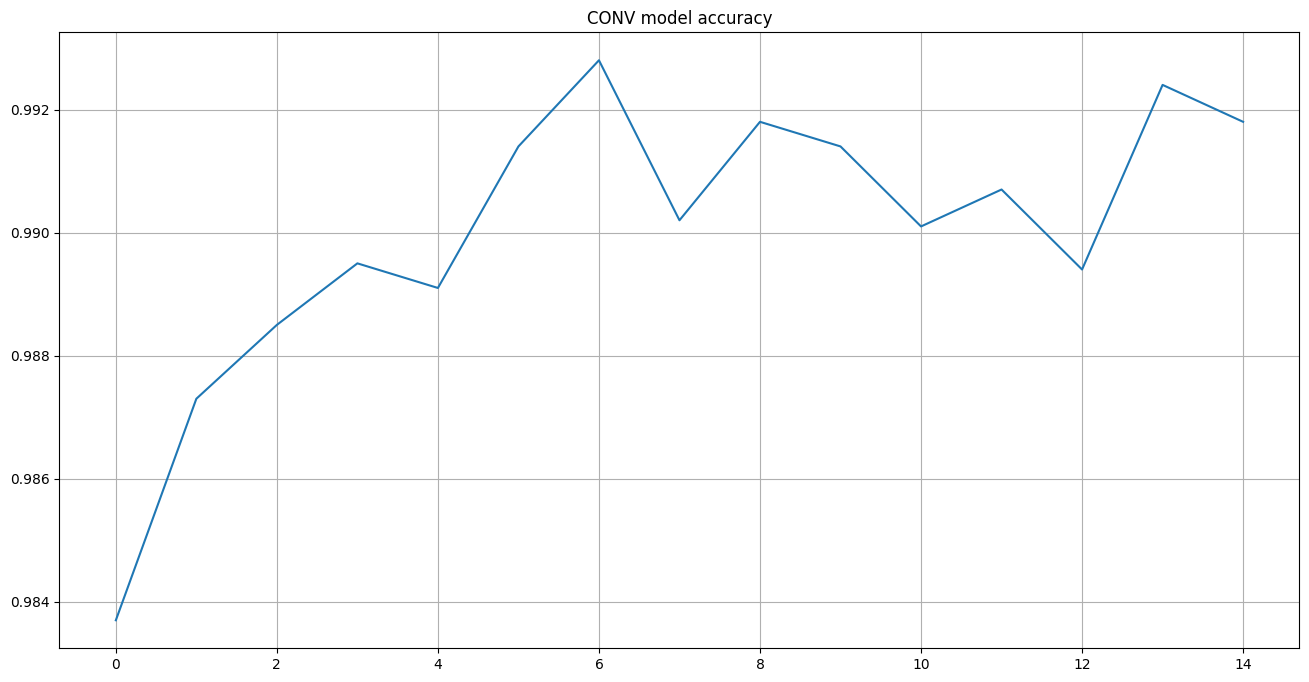

Total training and evaluation time 153.55341


In [38]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [39]:
torch.save(second_model, 'model.pt')

In [ ]:
image_path = 'path_to_dog_image.jpg'
image = Image.open(image_path)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# Make prediction
with torch.no_grad():
    output = resnet_model(input_batch)

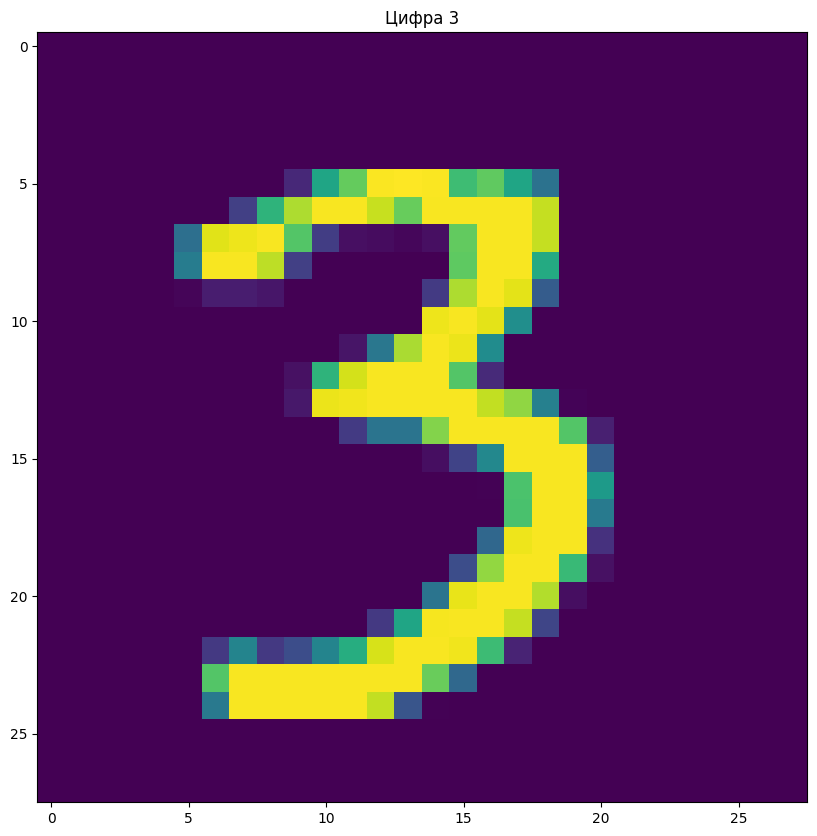

In [57]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {minist_train[10000][1]}')
plt.imshow(minist_train[10000][0][0])

plt.show()

In [46]:
second_model()

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [45]:
type(minist_train[10000][0])

torch.Tensor

In [47]:
x = minist_train[10000][0]

In [48]:
second_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=520, bias=True)
  (8): ReLU()
  (9): Linear(in_features=520, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=10, bias=True)
)

In [49]:
second_model.

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor